In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install -qq diffusers datasets accelerate wandb open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 29.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... 

In [3]:
from datasets import load_dataset, Image, Dataset

data = load_dataset("BirdL/DallData", split="train")
data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2851 [00:00<?, ? examples/s]

Dataset({
    features: ['Images'],
    num_rows: 2851
})

In [4]:
data[0]

{'Images': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>}

In [5]:
data

Dataset({
    features: ['Images'],
    num_rows: 2851
})

In [12]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
x = transforms.ToTensor()(data[0]["Images"]).unsqueeze_(0).to(device);
y = transforms.ToTensor()(data[1]["Images"]).unsqueeze_(0).to(device);
x.shape

torch.Size([1, 3, 256, 256])

In [17]:
torch.cat((x,y)).shape

torch.Size([2, 3, 256, 256])

In [18]:
data_tensor = transforms.ToTensor()(data[0]["Images"]).unsqueeze_(0).to(device)

for i in range(1, 2851):
  x = transforms.ToTensor()(data[i]["Images"]).unsqueeze_(0).to(device)
  data_tensor = torch.cat((data_tensor, x))

data_tensor.shape

torch.Size([2851, 3, 256, 256])

In [84]:
transform = transforms.ToTensor()
data_tensor = torch.empty((0,0,0), dtype=torch.float32)
data_tensor

tensor([], size=(0, 0, 0))

In [19]:
type(data_tensor)

torch.Tensor

In [21]:
data_loader = torch.utils.data.DataLoader(dataset = data_tensor, batch_size=64, shuffle = True)

In [22]:
data_loader

In [39]:
dataiter = iter(data_loader)
images = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


In [43]:
class Autoencoder_CNN(nn.Module):
    def __init__(self):
        #N, 3, 256,256 - no of pixels in the dataset
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), #N, 16,129,129
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), #N, 32,66,66
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), #N, 64, 31, 31
            nn.ReLU(),
            nn.Conv2d(64, 128, 11), #N, 128, 12, 12
        )

        # N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 11), #N, 32, 7,7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7), #N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(32,16, 3, stride=2, padding=1, output_padding=1), #N, 1, 28, 28
            nn.ReLU(),
            nn.ConvTranspose2d(16,3, 3, stride=2, padding=1, output_padding=1), #N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Note: take care of the range of values of iamges at the last layer of the decoder.

In [73]:
model = Autoencoder_CNN()
if torch.cuda.is_available():
    model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-5)

In [74]:
num_epoches = 50
outputs=[]
for epoch in range(num_epoches):
    for img in data_loader:
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch : {epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch : 1, Loss:0.0659
Epoch : 2, Loss:0.0339
Epoch : 3, Loss:0.0251
Epoch : 4, Loss:0.0233
Epoch : 5, Loss:0.0282
Epoch : 6, Loss:0.0258
Epoch : 7, Loss:0.0188
Epoch : 8, Loss:0.0192
Epoch : 9, Loss:0.0169
Epoch : 10, Loss:0.0206
Epoch : 11, Loss:0.0150
Epoch : 12, Loss:0.0183
Epoch : 13, Loss:0.0146
Epoch : 14, Loss:0.0168
Epoch : 15, Loss:0.0163
Epoch : 16, Loss:0.0125
Epoch : 17, Loss:0.0113
Epoch : 18, Loss:0.0163
Epoch : 19, Loss:0.0108
Epoch : 20, Loss:0.0141
Epoch : 21, Loss:0.0137
Epoch : 22, Loss:0.0105
Epoch : 23, Loss:0.0378
Epoch : 24, Loss:0.0311
Epoch : 25, Loss:0.0246
Epoch : 26, Loss:0.0230
Epoch : 27, Loss:0.0231
Epoch : 28, Loss:0.0184
Epoch : 29, Loss:0.0167
Epoch : 30, Loss:0.0194
Epoch : 31, Loss:0.0235
Epoch : 32, Loss:0.0149
Epoch : 33, Loss:0.0131
Epoch : 34, Loss:0.0123
Epoch : 35, Loss:0.0145
Epoch : 36, Loss:0.0183
Epoch : 37, Loss:0.0151
Epoch : 38, Loss:0.0168
Epoch : 39, Loss:0.0161
Epoch : 40, Loss:0.0132
Epoch : 41, Loss:0.0147
Epoch : 42, Loss:0.0104
E

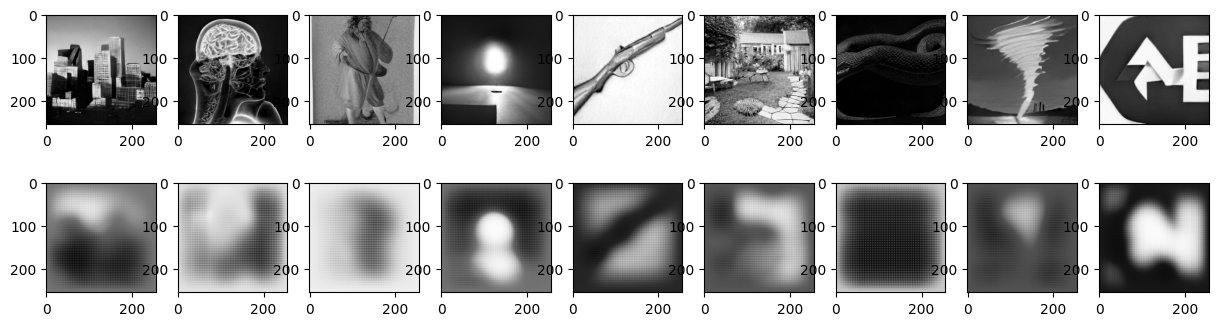

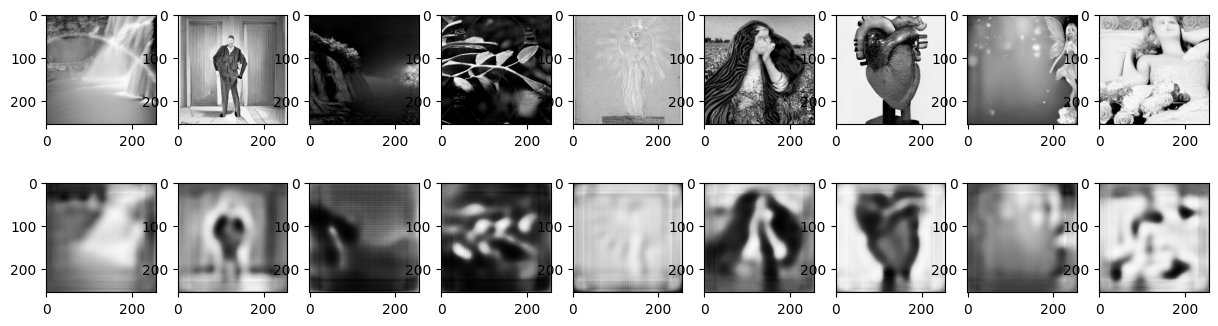

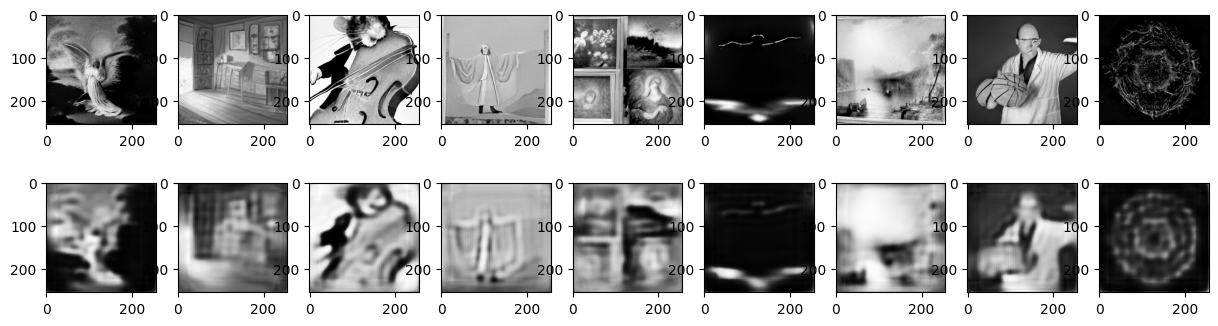

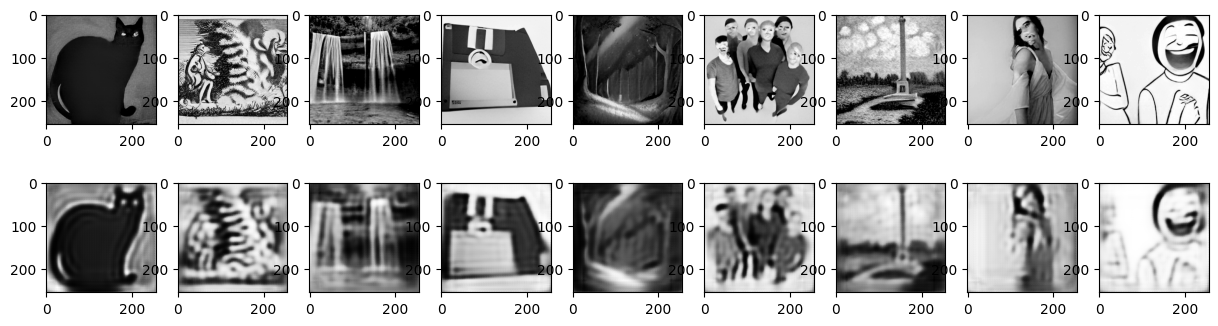

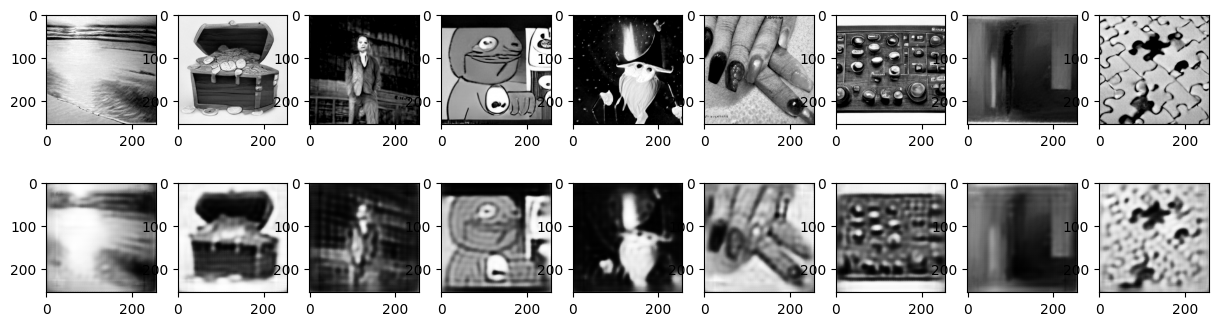

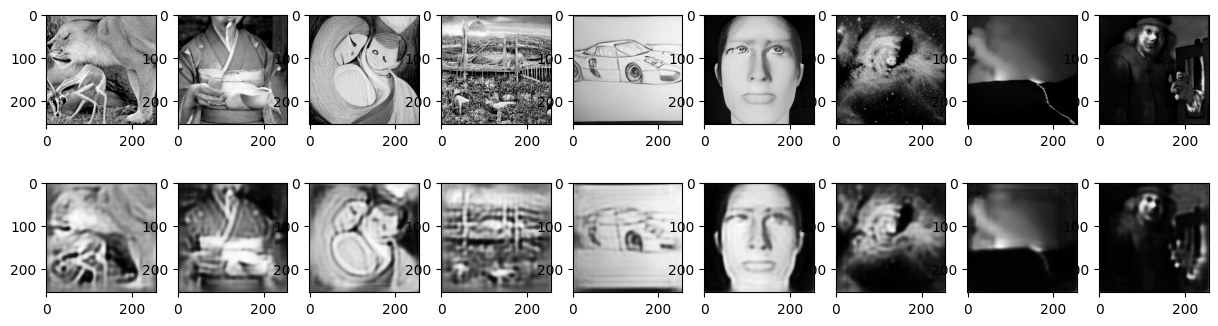

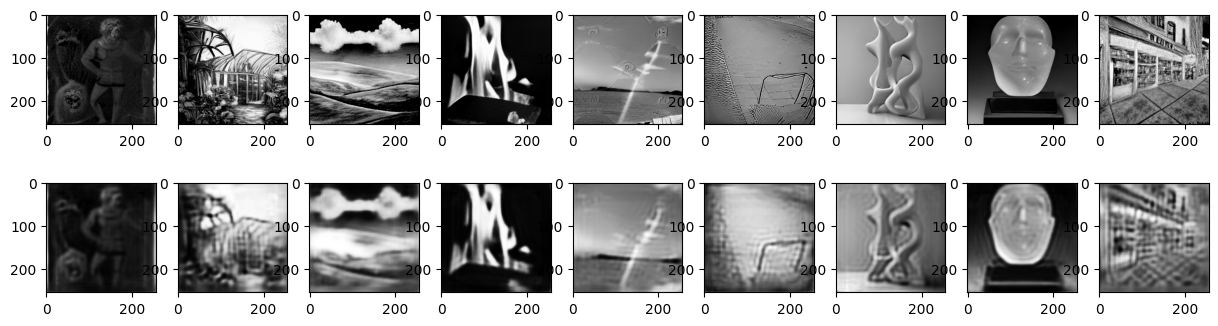

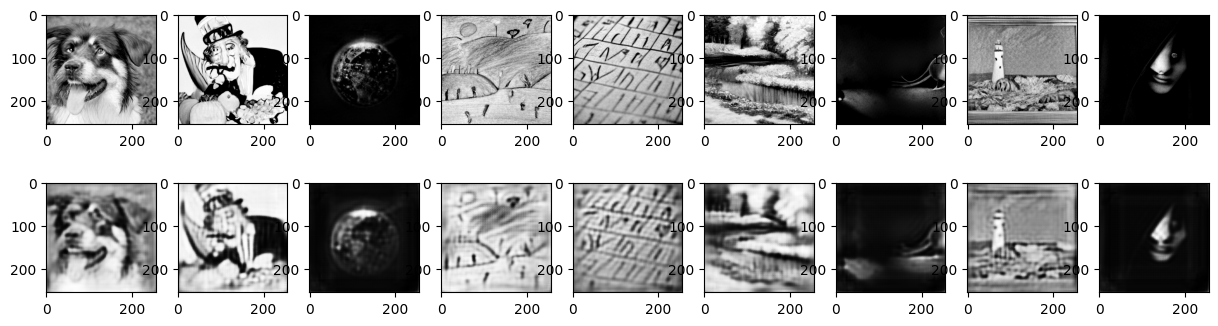

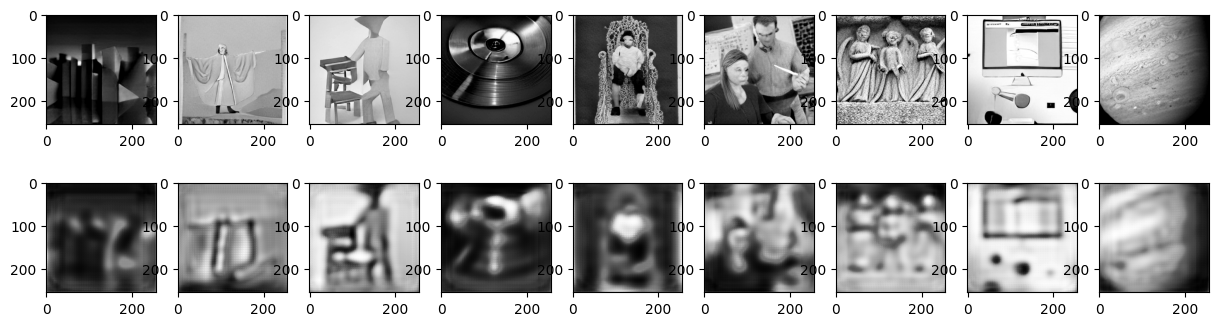

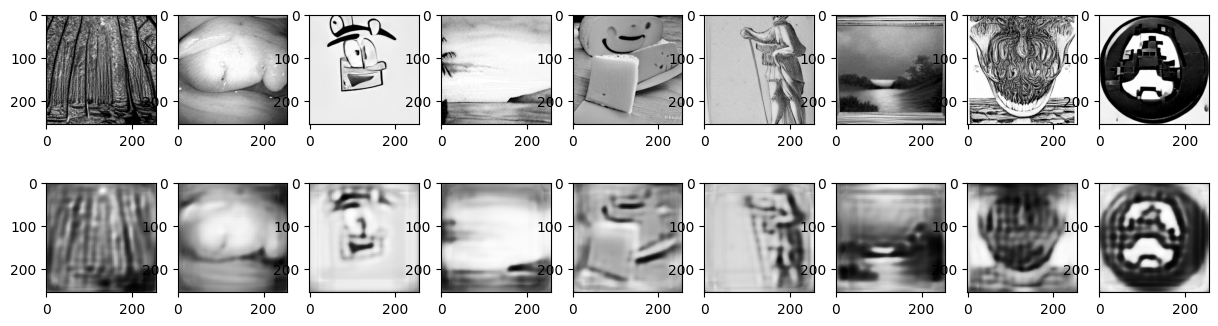

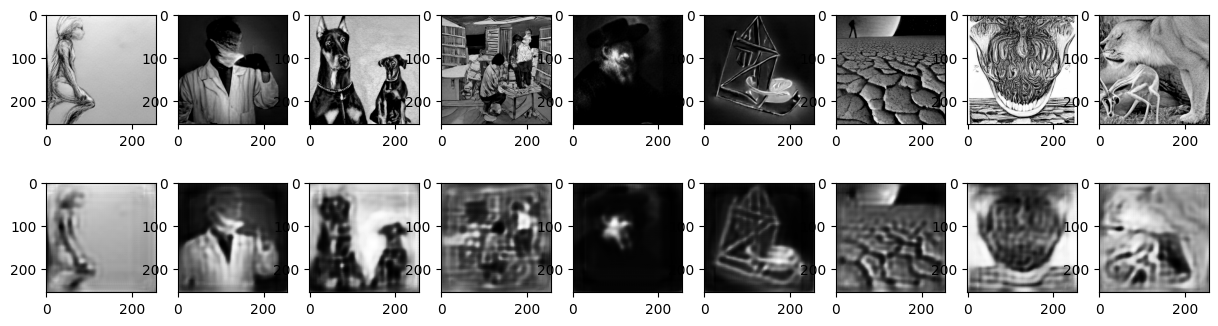

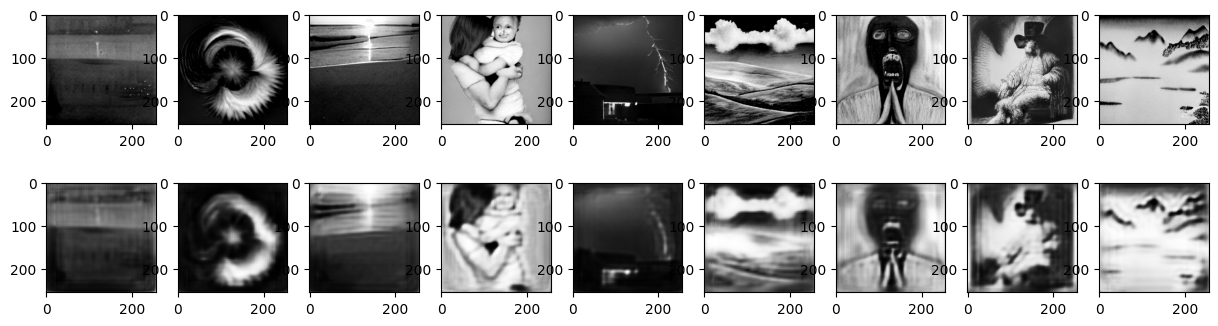

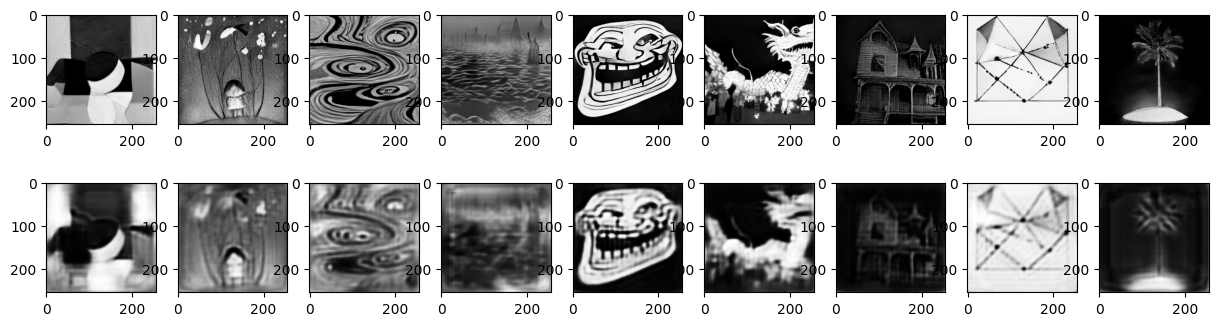

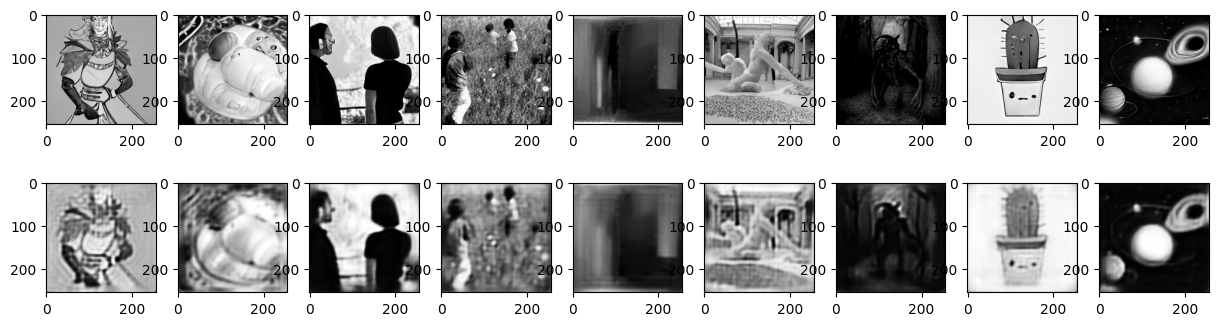

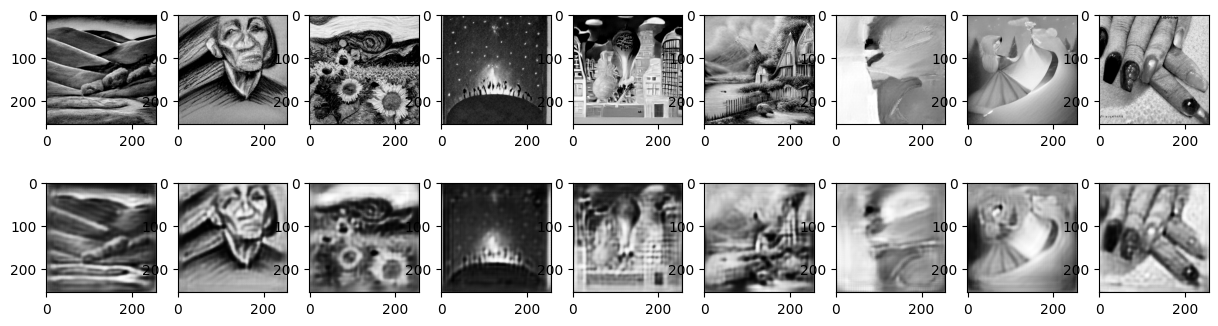

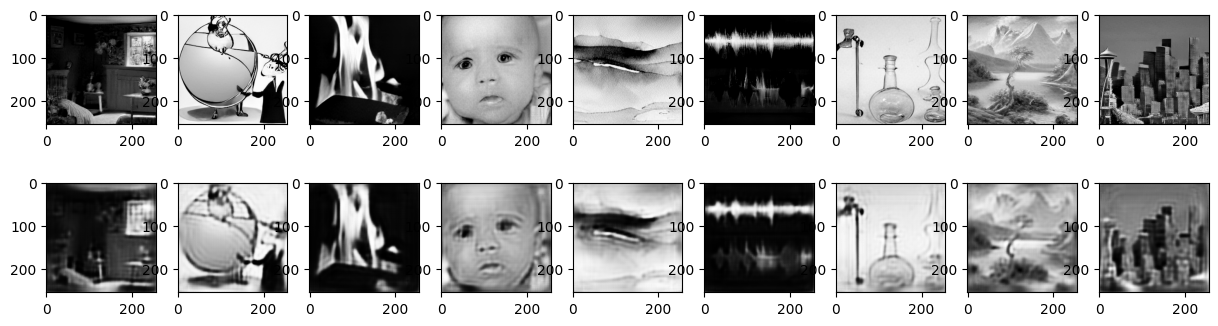

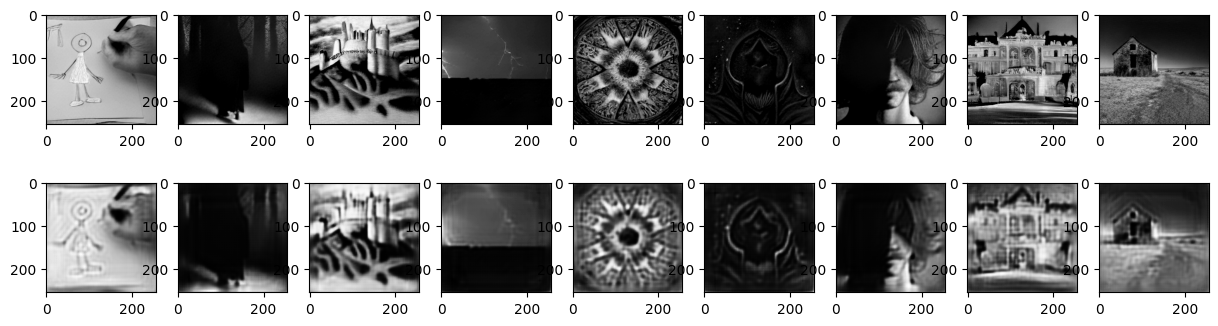

In [76]:
for k in range(0, num_epoches, 3):
    plt.figure(figsize= (15,4))
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(3, 256, 256)
        plt.imshow(item[0])
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, i+1+9)
        item = item.reshape(3, 256, 256)
        plt.imshow(item[0])